In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [2]:
cv2.__version__, np.__version__, matplotlib.__version__

('4.5.3', '1.21.5', '3.5.1')

# Задание 4 #

Морфологические операторы. Убрать мелкие дырки. Объединение объектов. Локализация на кадре объекта (дорожный знак, bar/qr код, регистрационный знак автомобиля и тому подобное). Фон произвольная картинка.

### Убрать мелкие дырки + Объединение объектов ###

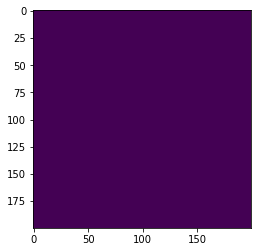

In [3]:
image = np.zeros((200,200)) # создадим пустое изображение
plt.imshow(image)

Создать рандомные фигуры

In [4]:
n_fig = 2 # 4 фигуры, 2 их них - с дырками
for fig in range(n_fig): 
    rad = np.random.random_integers(30, 70, 1)[0] # случайный радиус
    cntr = tuple(np.random.random_integers(0, image.shape[0], size = 2)) # две случайные координаты
    cv2.circle(img = image, center = cntr, radius = rad, color = 255, thickness = -1)
    pt1, pt2 = np.random.random_integers(0, image.shape[0], size = 2)
    cv2.rectangle(img = image, pt1 = (pt1, pt2), pt2=(pt1+rad, pt2+rad), color = 255, thickness = -1)

C:\Users\jeka_\AppData\Local\Temp/ipykernel_13072/2654781396.py:3: DeprecationWarning: This function is deprecated. Please call randint(30, 70 + 1) instead
  rad = np.random.random_integers(30, 70, 1)[0] # случайный радиус
C:\Users\jeka_\AppData\Local\Temp/ipykernel_13072/2654781396.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 200 + 1) instead
  cntr = tuple(np.random.random_integers(0, image.shape[0], size = 2)) # две случайные координаты
C:\Users\jeka_\AppData\Local\Temp/ipykernel_13072/2654781396.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 200 + 1) instead
  pt1, pt2 = np.random.random_integers(0, image.shape[0], size = 2)


Правильный тип даных

In [5]:
image = image.astype('uint8')

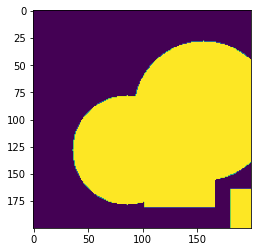

In [6]:
plt.imshow(image)

Теперь добавление шума - черных точек

In [7]:
rng = np.random.default_rng(0)

In [8]:
image_noise = image + ( rng.random( (image.shape[0], image.shape[1]) ) < 0.01 )

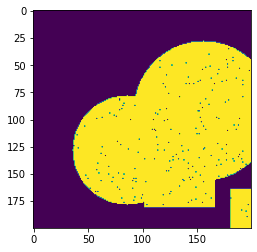

In [9]:
plt.imshow(image_noise)

**Очистка от шума через cv2.dilate()**

In [10]:
clean = cv2.dilate(image_noise, kernel = (7,7))

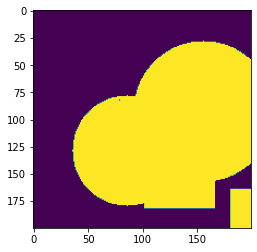

In [11]:
plt.imshow(clean)

### Локализация на кадре объекта ###

In [12]:
qr = cv2.imread('qr5.jpg')

In [13]:
qr = cv2.cvtColor(qr, cv2.COLOR_BGR2GRAY)

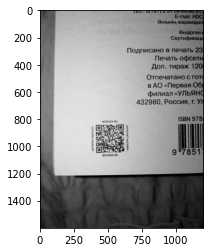

In [14]:
plt.imshow(qr, cmap = 'gray')

**Ищем производные для границ - по вертикали и по горизонтали**

In [15]:
grX = cv2.Sobel(qr, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
grY = cv2.Sobel(qr, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
common_gr = cv2.subtract(grX, grY)

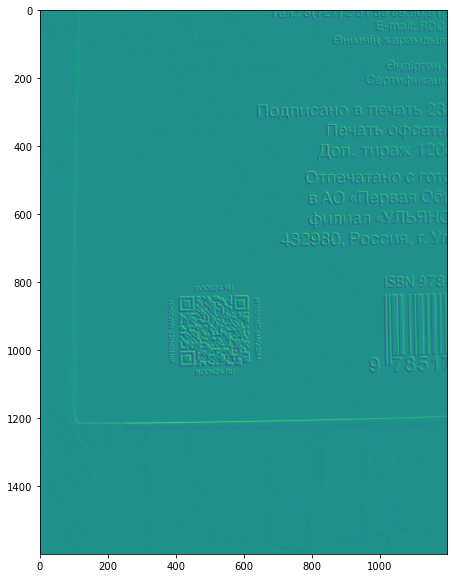

In [16]:
fig = plt.figure(figsize = (10,10))
plt.imshow(common_gr)

In [17]:
np.unique(common_gr)

array([-4122., -3898., -3868., ...,  3856.,  3868.,  4042.], dtype=float32)

Видно, что получившееся изображение содержит очень широкий диапазон значений, так что надо его отмасштабировать.

In [18]:
gradient_scaled = cv2.convertScaleAbs(common_gr)

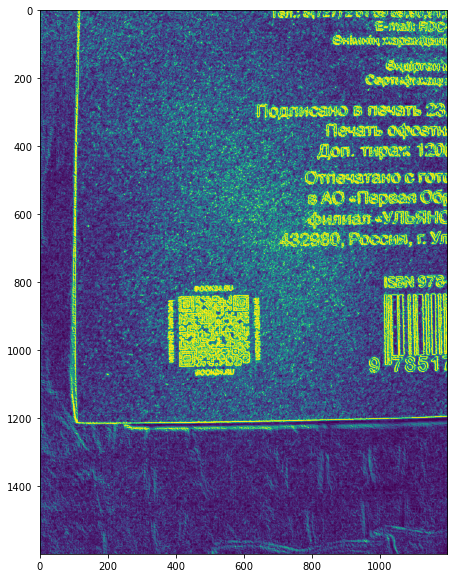

In [19]:
fig = plt.figure(figsize = (10,10))
plt.imshow(gradient_scaled)

In [20]:
np.unique(gradient_scaled) # вот теперь uint-8 и [0,255]

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 255],
      dtype=uint8)

Теперь можно применить порог:

In [21]:
_, img_tr = cv2.threshold(gradient_scaled, 128, 255, cv2.THRESH_BINARY)

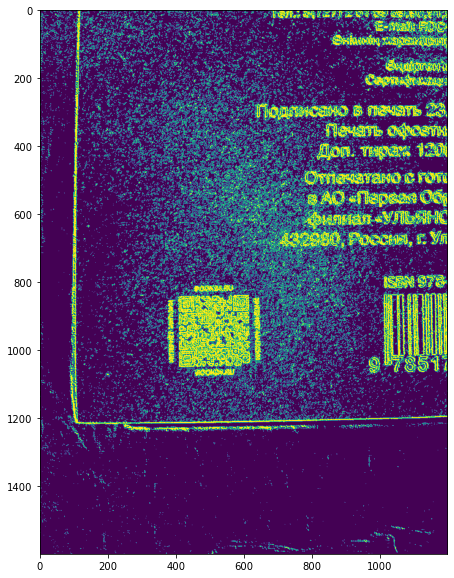

In [22]:
fig = plt.figure(figsize = (10,10))
plt.imshow(img_tr)

Выделение элементов:

In [23]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
code = cv2.morphologyEx(img_tr, cv2.MORPH_CLOSE, kernel)

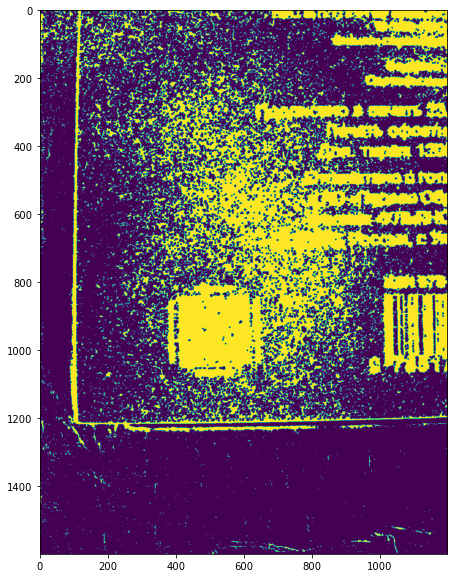

In [24]:
fig = plt.figure(figsize = (10,10))
plt.imshow(code)

In [25]:
# немного убрать лишнее, но не сильно, чтобы не уменьшить контуры самого кода
code_clear = cv2.erode(code, None, iterations = 10)

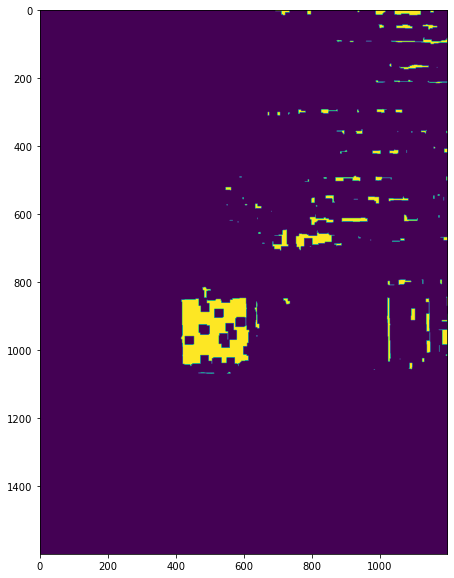

In [26]:
fig = plt.figure(figsize = (10,10))
plt.imshow(code_clear)

**Далее достаточно просто извлечь компоненту с самой большой площадью.**

In [27]:
comp = cv2.connectedComponentsWithStats(code_clear)

In [28]:
stats = comp[2].copy()

In [29]:
stats

array([[      0,       0,    1200,    1600, 1872418],
       [    692,       0,      42,      15,     303],
       [    786,       0,      11,      13,     142],
       [    934,       0,       5,       6,      30],
       [    987,       0,      29,      14,     352],
       [   1043,       0,      77,      15,    1024],
       [   1148,       0,      10,       7,      70],
       [    996,      43,      16,      10,     115],
       [   1048,      43,      47,      11,     390],
       [   1126,      42,      42,      15,     274],
       [   1034,      80,     166,      20,     828],
       [    873,      88,      15,       6,      47],
       [    911,      91,      11,       3,      31],
       [    959,      91,      16,       1,      16],
       [   1028,     158,       6,       9,      36],
       [   1057,     161,      86,      13,     524],
       [   1167,     168,       2,       1,       2],
       [    988,     207,      27,       6,      70],
       [   1042,     206,   

In [30]:
qr_code_ = sorted(stats, key= lambda stats: stats[4], reverse = True)[1] # самая большая - фон, нужна 1-вая

In [31]:
qr_code_ # левый верхний угол и правый нижний 

array([  415,   847,   200,   200, 27402], dtype=int32)

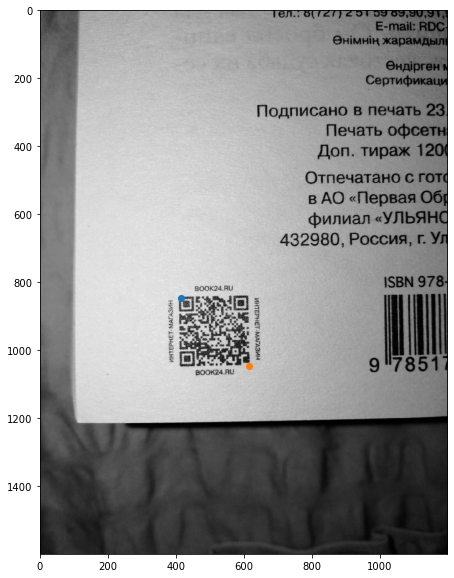

In [32]:
# можно даже посмотреть на вывод
fig = plt.figure(figsize = (10,10))
plt.imshow(qr, cmap = 'gray')
plt.scatter(x = (qr_code_[0],), y = (qr_code_[1],))
plt.scatter(x = (qr_code_[0]+qr_code_[2],), y = (qr_code_[1]+qr_code_[3],))

**Теперь есть координаты прямоугольника и можно просто его нарисовать поверх изначального изображения**

In [33]:
pt1 = tuple(qr_code_[0:2])
pt2 = (qr_code_[0] + qr_code_[2], qr_code_[1] + qr_code_[3])

In [34]:
pt1, pt2

((415, 847), (615, 1047))

In [35]:
cv2.rectangle(qr, pt1, pt2, color = 0, thickness = 5) # рисование поверх

array([[94, 96, 98, ..., 37, 55, 64],
       [94, 96, 97, ..., 43, 64, 73],
       [94, 95, 95, ..., 44, 63, 69],
       ...,
       [19, 19, 19, ...,  2,  3,  3],
       [21, 21, 21, ...,  2,  3,  3],
       [23, 23, 22, ...,  2,  3,  3]], dtype=uint8)

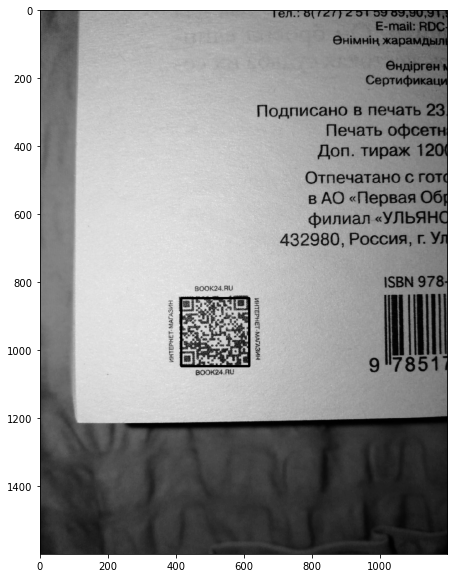

In [36]:
fig = plt.figure(figsize = (10,10))
plt.imshow(qr, cmap = 'gray')

Вроде довольно неплохо выглядит.

Можно вывести отдельно только сам QR-код.

In [37]:
code_for_detect = qr[pt1[1]:pt2[1], pt1[0]:pt2[0]]

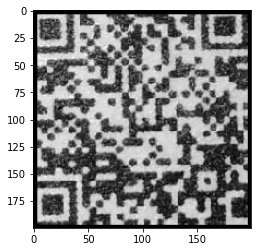

In [38]:
plt.imshow(code_for_detect, cmap = 'gray')

# Задание 5 #

Считать информацию из найденного объекта (из bar\qr кода, определение дорожного знака, номера на регистрационном знаке автомобиля).

### Только библиотекой (простой вариант через cv2.QRCodeDetector) ###

В этом случае можно просто заново загрузить изображение, но необходимо его немного обработать, чтобы облегчить функции восприятие qr-кода (без обработки не работает, просто:-) )

In [39]:
qr3 = cv2.imread('qr5.jpg')
qr3 = cv2.cvtColor(qr3, cv2.COLOR_BGR2GRAY)

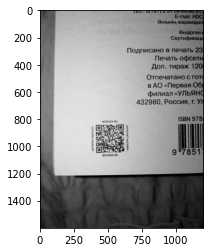

In [40]:
plt.imshow(qr3, cmap = 'gray')

Применение порога

In [41]:
_, qr3_tr = cv2.threshold(qr3, 110, 255, type = cv2.THRESH_BINARY) # 110

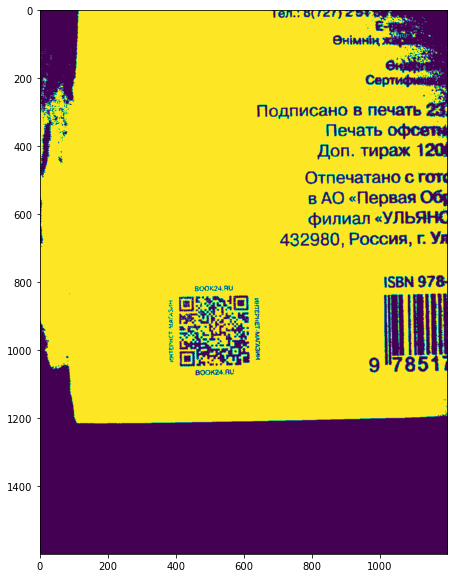

In [42]:
fig = plt.figure(figsize = (10,10))
plt.imshow(qr3_tr)

Создание объекта класса QRCodeDetector

In [43]:
qrDecoder = cv2.QRCodeDetector()

In [44]:
points_ = qrDecoder.detect(qr3_tr)

In [45]:
points_

(True,
 array([[[ 409.     ,  844.     ],
         [ 611.     ,  841.     ],
         [ 616.45917, 1043.3175 ],
         [ 413.     , 1047.     ]]], dtype=float32))

In [46]:
points_[1] # края qr-кода

array([[[ 409.     ,  844.     ],
        [ 611.     ,  841.     ],
        [ 616.45917, 1043.3175 ],
        [ 413.     , 1047.     ]]], dtype=float32)

In [47]:
data = qrDecoder.decode(qr3_tr, points = points_[1])#.astype('float32'))

In [48]:
data # информация

('https://book24.ru/?utm_source=qrcode&utm_medium=books',
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  0, 255, 255, ..., 255, 255,   0],
        [  0, 255,   0, ...,   0, 255,   0],
        ...,
        [  0, 255,   0, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8))

### Немного руками ###

Но можно сделать свою реализацию функции decode (тоже самое, что и в 4-том занятии)

In [49]:
def detect(img: str = 'qr5.jpg', trash: int = 110, iterations: int = 10):
    qr = cv2.imread(img)
    qr = cv2.cvtColor(qr, cv2.COLOR_BGR2GRAY)
    grX = cv2.Sobel(qr, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    grY = cv2.Sobel(qr, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
    common_gr = cv2.subtract(grX, grY)
    gradient_scaled = cv2.convertScaleAbs(common_gr)
    _, img_tr = cv2.threshold(gradient_scaled, 128, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    code = cv2.morphologyEx(img_tr, cv2.MORPH_CLOSE, kernel)
    code_clear = cv2.erode(code, None, iterations = iterations)
    comp = cv2.connectedComponentsWithStats(code_clear)
    qr_code_ = sorted(stats, key= lambda stats: stats[4], reverse = True)[1] # самая большая - фон, нужна 1-вая
    pt1 = tuple(qr_code_[0:2])
    pt2 = (qr_code_[0] + qr_code_[2], qr_code_[1] + qr_code_[3])
    pt1 = np.array(pt1) # левый верхний
    pt2 = np.array(pt2) # правый нижний
    pt3 = np.array([pt2[0], pt1[1]]) # нижний левый
    pt4 = np.array([pt1[0], pt2[1]]) # верхний правый
    points = np.array([pt1, pt3, pt2, pt4])  # верхний левый угол, нижний левый, нижний правый, верхний правый
    img = qr.copy()
    #fig = plt.figure(figsize = (10,10))
    #cv2.rectangle(img, pt1, pt2, color = 0, thickness = 5)
    #plt.imshow(img, cmap = 'gray')
    #plt.scatter(x = (qr_code_[0],), y = (qr_code_[1],))
    #plt.scatter(x = (qr_code_[0]+qr_code_[2],), y = (qr_code_[1]+qr_code_[3],))
    
    return img, np.array([points])
    

Немного поиска по сетке, чтобы понять, при каких гиперпараметрах он все-таки будет работать, хоть и почти при всех этих параметрах сама рамка почти одинаковая

In [50]:
qrDecoder = cv2.QRCodeDetector()

In [60]:
for i in range(110, 175):
    for j in range(1, 15):
        img, po = detect(trash = i, iterations = j)
        a,b = qrDecoder.decode(img, points = po )
        if (a != ''):
            print (i,j)

Ничего не вывелось, значит объекту не нравятся  границы (хотя они очень похожи - ниже пример)

Но, выделяет почти те же самые границы, что и библиотечный.

Иллюстрация:

**Рамка из библиотечной функции**

In [51]:
points_[1] # вывод точек библиотечной функции

array([[[ 409.     ,  844.     ],
        [ 611.     ,  841.     ],
        [ 616.45917, 1043.3175 ],
        [ 413.     , 1047.     ]]], dtype=float32)

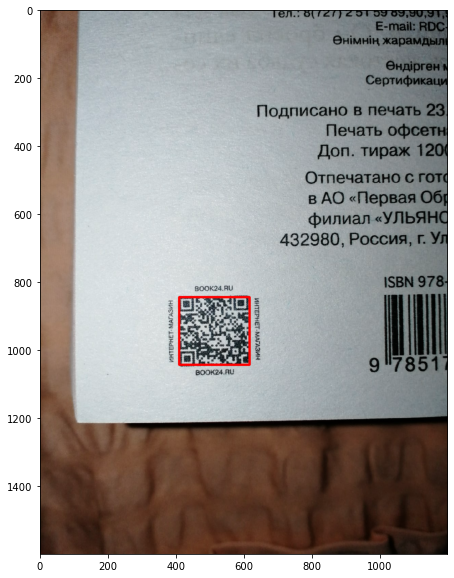

In [52]:
qr = cv2.imread('qr5.jpg')
img_1 = qr.copy()
fig = plt.figure(figsize = (10,10))
cv2.rectangle(img_1, pt1 = tuple(points_[1][0][0].astype('int32')), 
              pt2 = tuple(points_[1][0][2].astype('int32')), 
              color = 255, thickness = 5)
plt.imshow(img_1)

**Рамка из своей функции**

In [55]:
img, po = detect(trash = 110, iterations = 10)
po

array([[[ 415,  847],
        [ 615,  847],
        [ 615, 1047],
        [ 415, 1047]]], dtype=int32)

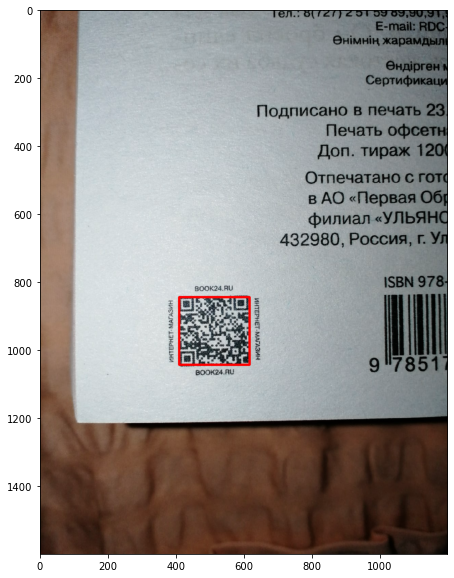

In [56]:
img_2 = qr.copy()
fig = plt.figure(figsize = (10,10))
cv2.rectangle(img_2, pt1 = tuple(po[0][0].astype('int32')), 
              pt2 = tuple(po[0][2].astype('int32')), 
              color = 255, thickness = 5)
plt.imshow(img_1)

Почти тоже самое, но с такой рамкой функция decode не работает

In [59]:
img_2 = qr.copy()
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
_, qr3_tr = cv2.threshold(img_2, 110, 255, type = cv2.THRESH_BINARY) # 110

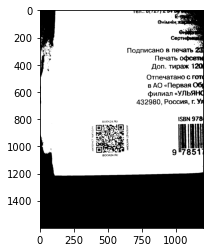

In [60]:
plt.imshow(qr3_tr, cmap = 'gray')

In [67]:
data_ = qrDecoder.decode(qr3_tr, points = po)

In [68]:
data_ # но с почти такой же рамкой - не хочет принимать

('', None)